# Bayesian detection of abnormal region detector - BARD

All the algorithms used in this notebooks were proposed by Lawrence and Fearnhead (2016).

Let's load some packages to plot and import example dataset.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The dataset is an artificial dataset simulated as described by Lawrence and Fearnhead (2016). It's a simulated data from the model assumed by BARD algorithm with length 1084 and number of dimensions fixed at 200. The LOS distributios were:

$$ S_N \sim NBinom(10,0.1)$$ and $$ S_A \sim NBinom(15,0.3)$$

The distributions for normal segments is 

$$ \mathcal{D} \sim N(0,\sigma^{2}) $$

and for abnormal segments is

$$ \mathcal{P}_{\mu} \sim N(\mu,\sigma^{2}) $$

with a uniform prior on $\mu$

$$ \mu \sim U(0.3,0.7) $$.

The model assumes that the variance $\sigma^{2}$ is constant and known.

In [4]:
data = np.loadtxt("temp.csv", delimiter=",")
cpts = np.loadtxt("cpts.csv", delimiter=",", dtype=int)
data.shape

(1084, 200)

We simulate and stored the datas from a single simulation to allow us a comparison between BARD encoded in `R` (bard-R) and our implementation in python (bard-py) using the same data.

Bellow we can have a taste of what data looks like in lower dimensions (d=10).

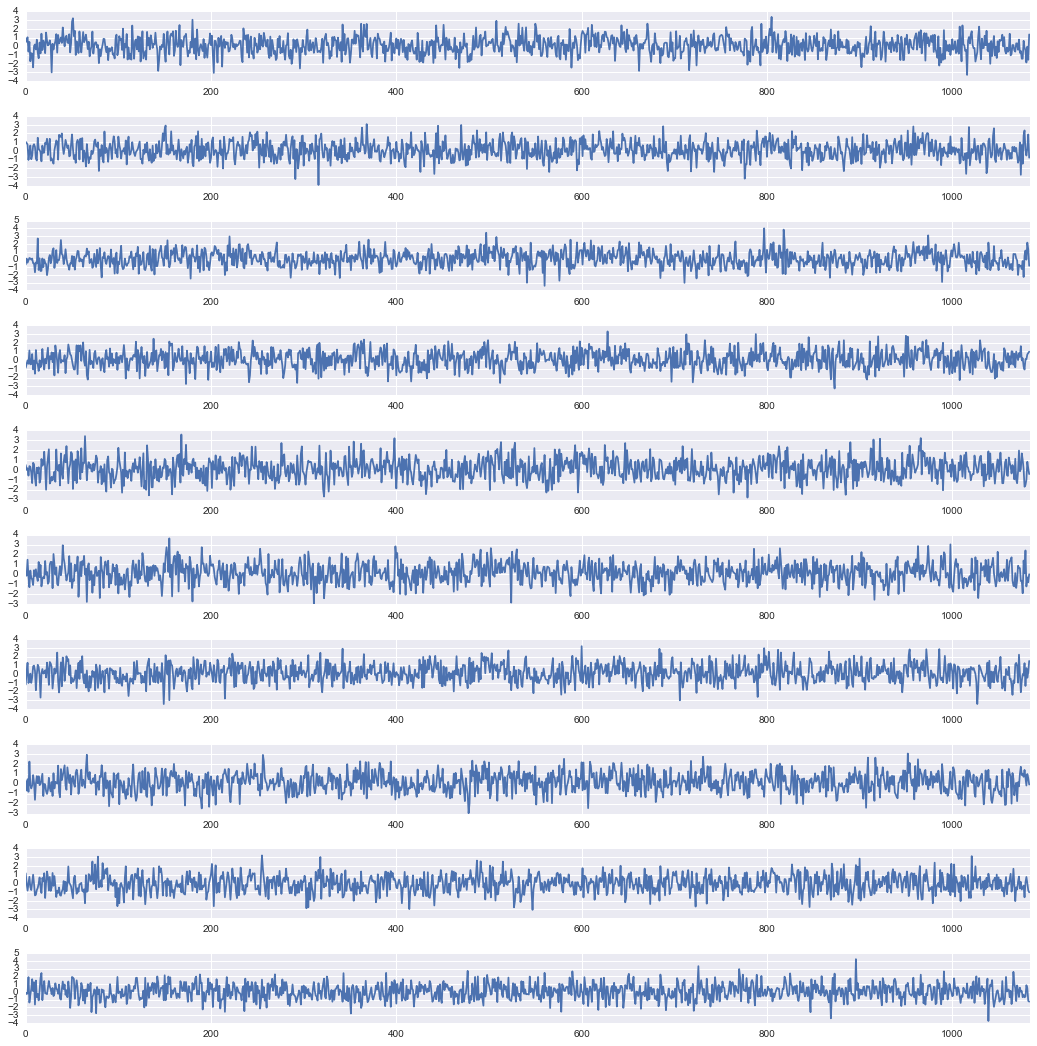

In [5]:
plt.subplots(figsize=[18, 20])
for x in np.arange(10):
    plt.subplot(10+1,1,1+x)
    plt.plot(np.arange(data.shape[0]), data[:,x])
    plt.xlim(0,data.shape[0])
#for x in xrange(len(cpts)):
#    plt.axvline(cpts[x], color='k', linestyle='--')

Note that even reducing the dimensions we're not capable of segment the data by eye. In the example dataset above we have 18 changepoints. Now, lets load the bard algorithm and try to predict the abnormal segments changepoint locations. All the parameters for our model as described in Lawrence and Fearnhead (2016) are in a json file named `model.json`. So the function `SRC_filtering` is a stratified rejection control algorithm to produce an approximation to perform approximate inference. In these function we have to specify our data, the expected number of abnormal dimensions, the model name and file.

In [6]:
from BARD_python.bardbard import SRC_filtering

%time ww, ll, tt = SRC_filtering(data,8,"lawrence", "BARD_python/model.json")

CPU times: user 57.7 s, sys: 160 ms, total: 57.8 s
Wall time: 57.8 s


After finished the filtering distributions calculations we sample n=1000 times from posterior distribution with the function `get_prob_vec`.

In [7]:
from BARD_python.bardbard import get_prob_vec

%time prob_vec = get_prob_vec(ww, ll, tt, "lawrence", "BARD_python/model.json", 1000)

CPU times: user 7.9 s, sys: 20 ms, total: 7.92 s
Wall time: 7.92 s


The graphic bellow shows in top frame a plot for the median of all dimensions and, in bottom, the true changepoints in dashed line and the probability of point x be in an abnormal segment. If we wish we could define a threshold and segment the data in normal or abnormal segments.

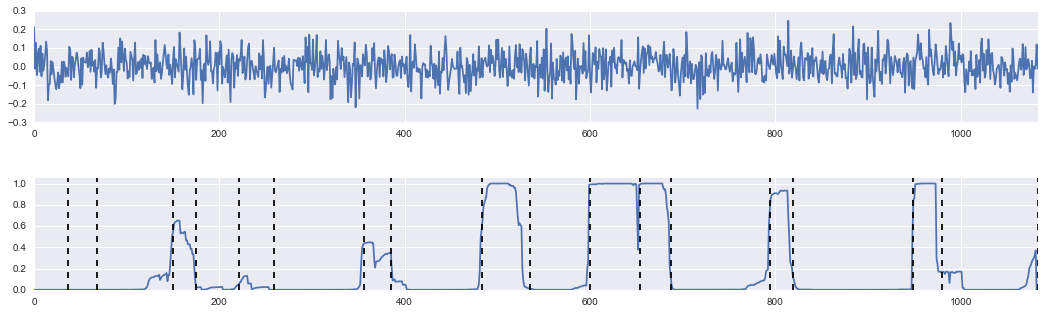

In [8]:
n = data.shape[0]
plt.subplots(figsize=[18, 5])
plt.subplot(2,1,1)
plt.plot(np.arange(n), np.mean(data, axis = 1))
plt.xlim([0,n])
plt.subplot(2,1,2)
plt.plot(np.arange(n), prob_vec)
plt.xlim([0,n])
plt.ylim([0,1.05])
for x in xrange(len(cpts)):
    plt.axvline(cpts[x], color='k', linestyle='--')

### Bibliography

Bardwell, Lawrence, and Paul Fearnhead. 2016. “Bayesian Detection of Abnormal Segments in Multiple Time Series.” Bayesian Analysis, February. doi:10.1214/16-BA998.

## Poisson model

In [23]:
from scipy.stats import nbinom
import numpy as np

k_A = 15
p_A = 0.3

k_N = 10
p_N = 0.1

pi_A = 0.2
pi_N = 0.8
# simulate from the model -- data like from the first simulation study 
# in the paper, dimension 200 and length approx 1000

# n.max is a soft maximum on length of data set 
n_max = 1000

# fixed no of dimensions and no of affected dimensions i.e. 4% 
N = 20
affected_dim = 8

# start in a normal state encoded as 0 
cpts = np.random.negative_binomial(k_N, p_N, 1)
state = np.repeat(np.array(["N"]), cpts)

kn = 10
thetan = 2.

alfaa = 2.5
betaa = 6.25
data = np.random.poisson(kn, size = (cpts,N))
curr_state = 0
n = cpts

while (n < n_max):
    # if current state is normal - draw abnormal length
    if curr_state == 0:
        
        # in normal transition to abnormal length ~ NBinom( k_A , p_A )
        seq_length = np.random.negative_binomial(k_A, p_A, 1)
        cpts = np.append(cpts, cpts[-1]+seq_length)
        state = np.append(state, np.repeat(np.array(["A"]), seq_length))

        # grow data seg.length no of rows
        data = np.concatenate([data, np.random.poisson(kn, size = (seq_length, N))], axis=0)

        # draw value of mu for dims with affected means
        mu = np.random.gamma(alfaa, betaa, 1)
        data[cpts[-2]+1:cpts[-1], 1:affected_dim] = data[cpts[-2]+1:cpts[-1], 1:affected_dim] + mu
        
        curr_state = 1
    
    else:
        # current state is abnormal curr_state == 1
        # with prob pi.N go to Normal
        # with prob pi.A go to Abnormal with diff mu
        # generate a u bernoulli with probs pi.A, pi.N
        
        u = np.random.binomial(1, pi_A, 1)
        
        # u==0 transition to normal
        if u == 0:
            
            seq_length = np.random.negative_binomial(k_N, p_N, 1)
            cpts = np.append(cpts, cpts[-1]+seq_length)
            state = np.append(state, np.repeat(np.array(["N"]), seq_length))
            
            # grow data seq_length no of rows
            data = np.concatenate([data, np.random.poisson(kn, size=(seq_length, N))], axis=0)
            
            curr_state = 0
            
        else:
            
            # u==1 thus transition to abnormal
            
            seq_length = np.random.negative_binomial(k_A, p_A, 1)
            cpts = np.append(cpts, cpts[-1]+seq_length)
            state = np.append(state, np.repeat(np.array(["A"]), seq_length))
            
            # grow data seq_length no of rows
            data = np.concatenate([data, np.random.poisson(kn,size=(seq_length, N))], axis=0)
            
            # random dimensions to affect ran.affec
            # ran.affec is first one
            
            mu = np.random.gamma(alfaa, betaa, 1)
            
            ran_affec = np.random.choice(np.arange(affected_dim, N-affected_dim), 1)
            data[cpts[-2]+1:cpts[-1], ran_affec:ran_affec+affected_dim] = data[cpts[-2]+1:cpts[-1], ran_affec:ran_affec+affected_dim] + mu
            
            curr_state = 1
    
    n = cpts[-1]

print "shape", data.shape

shape (1005, 20)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:69: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:82: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:90: DeprecationWar

In [24]:
data.shape

(1005, 20)

In [34]:
from BARD_python.bardbard import SRC_filtering, P_A, P_N

In [16]:
ww, ll, tt = SRC_filtering(data, 8,"lawrence", "BARD_python/model.json")

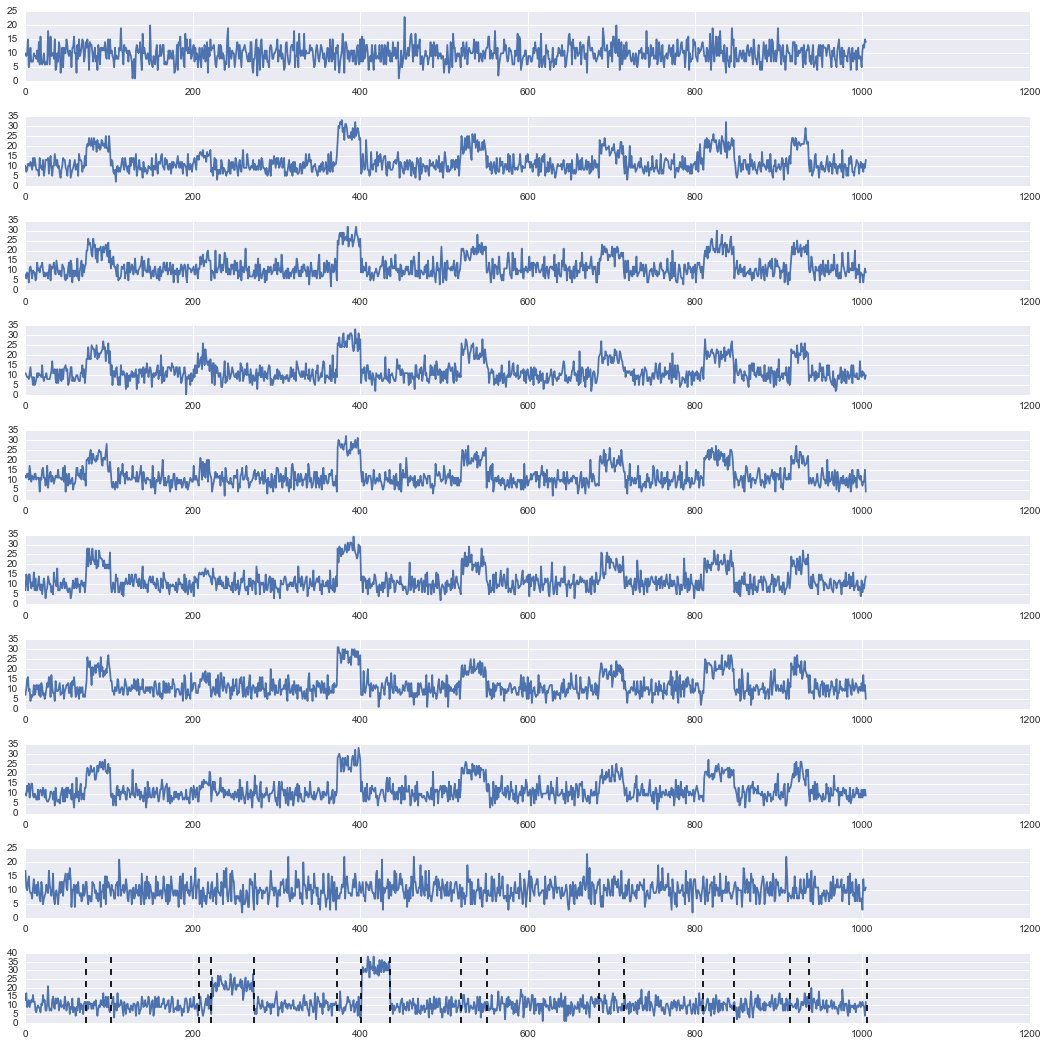

In [25]:
plt.subplots(figsize=[18, 20])
for x in np.arange(10):
    plt.subplot(10+1,1,1+x)
    plt.plot(np.arange(data.shape[0]), data[:,x])
for x in xrange(len(cpts)):
    plt.axvline(cpts[x], color='k', linestyle='--')

In [26]:
cpts

array([  72,  102,  207,  222,  273,  372,  401,  436,  520,  551,  685,
        715,  810,  847,  914,  936, 1005])

In [86]:
from scipy.misc import logsumexp
from scipy.special import gammaln

def P_A(s,t,mu_seq,S,N,p):
    lambd=10
    rgamma=6.25
    sgamma=2.5
    dt=S
    # width of rectangle
    mu_wid = np.diff(mu_seq)[0]
    # vector to populate
    vec = np.zeros(len(mu_seq))
    # evaluate at each point of grid
    # do this as typically smaller than dimension
    # evaluating log of quantity
    sumS = np.sum(dt[s:t+1,], axis=1)
    for k in xrange(0,len(mu_seq)):
        vec[k] = np.sum(p*np.exp(-mu_seq[k]*(s+t-1))*mu_seq[k]**(sumS) + (1-p)*np.exp(-lambd*(s-t+1))*lambd**(sumS)) + rgamma*np.log(sgamma) - gammaln(rgamma) + (rgamma-1)*np.log(mu_seq[k]) - s*mu_seq[k]
    print vec
    cmax = np.amax(vec)
    marg_like = cmax + logsumexp(vec - cmax)
    return marg_like

In [87]:
mu_seq = np.arange(0., 40., 2.5)
S=data
p=200./8
s=1
t=15
print P_A(s,t,mu_seq,S,S.shape[1],p)
print P_N(s,t,data)

[  0. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf]
0.0
9470.91391749
